In [22]:
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq import marginal_query
from twinify.napsu_mq.markov_network import MarkovNetwork
from twinify.napsu_mq import maximum_entropy_inference as mei
from twinify.napsu_mq import privacy_accounting
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import arviz as az
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
n = 2000
n_syn_datasets = 50
n_syn_dataset = n

epsilon = 1.0
delta = n**(-2)

conf_levels = np.linspace(0.05, 0.95, 19)
true_params = jnp.array((1.0, 0.0))
d = true_params.shape[0] + 1

def gen_data(rng):
    data_gen = BinaryLogisticRegressionDataGenerator(true_params)
    data = data_gen.generate_data(n, rng)
    x_values = data_gen.x_values
    values_by_feature = data_gen.values_by_feature

    return data, x_values, values_by_feature

def get_dp_suff_stat(rng, queries, data):
    suff_stat = jnp.sum(queries.flatten()(data), axis=0)
    sensitivity = np.sqrt(suff_stat.shape[0])
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
    dp_suff_stat = suff_stat + sigma_DP * jax.random.normal(key=rng, shape=suff_stat.shape)
    return dp_suff_stat, sigma_DP

def get_dp_suff_stat_flat(rng, queries, data):
    suff_stat = jnp.sum(queries(data), axis=0)
    sensitivity = np.sqrt(suff_stat.shape[0])
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
    dp_suff_stat = suff_stat + sigma_DP * jax.random.normal(key=rng, shape=suff_stat.shape)
    return dp_suff_stat, sigma_DP

def generate_synthetic_data(sampling_rng, posterior_values, n_syn_dataset, max_ent_dist):
    n_syn_datasets = posterior_values.shape[0]
    syn_datasets = jnp.zeros((n_syn_datasets, n_syn_dataset, max_ent_dist.d))
    data_keys = jax.random.split(sampling_rng, n_syn_datasets)
    for i in tqdm(range(n_syn_datasets)):
        syn_datasets = syn_datasets.at[i, :, :].set(
            max_ent_dist.sample(data_keys[i], posterior_values[i, :], n_syn_dataset)
        )
    return syn_datasets

In [47]:
rng_key = jax.random.PRNGKey(468236482)
inference_rng, sampling_rng, data_gen_rng, noise_key = jax.random.split(rng_key, 4)
data, x_values, values_by_feature = gen_data(data_gen_rng)

queries = marginal_query.FullMarginalQuerySet([tuple(range(d))], values_by_feature)
max_ent_dist = MarkovNetwork(values_by_feature, queries)

dp_suff_stat, sigma_DP = get_dp_suff_stat(noise_key, queries, data)

In [48]:
mcmc = mei.run_numpyro_mcmc(
    inference_rng, dp_suff_stat, n, sigma_DP, max_ent_dist, 
    num_samples=5000, num_warmup=1000, num_chains=4, disable_progressbar=False,
)
inf_data = az.from_numpyro(mcmc, log_likelihood=False)
posterior_values = inf_data.posterior.stack(draws=("chain", "draw"))
posterior_values = posterior_values.lambdas.values.transpose()

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:01<00:00, 3620.24it/s, 7 steps of size 1.56e-02. acc. prob=0.90]


In [49]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambdas[0],0.116,3.586,-6.229,7.206,0.122,0.115,887.0,810.0,1.0
lambdas[1],-0.026,3.586,-6.412,7.011,0.122,0.115,887.0,797.0,1.0
lambdas[2],-0.110,3.587,-6.564,6.858,0.122,0.116,887.0,792.0,1.0
lambdas[3],0.079,3.587,-6.336,7.090,0.122,0.115,887.0,790.0,1.0
lambdas[4],-0.519,3.587,-7.071,6.369,0.122,0.116,889.0,810.0,1.0
lambdas[5],0.459,3.586,-5.889,7.547,0.122,0.112,887.0,802.0,1.0
lambdas[6],-0.850,3.588,-7.164,6.297,0.122,0.116,886.0,800.0,1.0
lambdas[7],0.524,3.586,-5.880,7.536,0.122,0.112,887.0,801.0,1.0


In [66]:
laplace_approx, diagnostics = mei.run_numpyro_laplace_approximation(
    inference_rng, dp_suff_stat, n, sigma_DP, max_ent_dist,
)

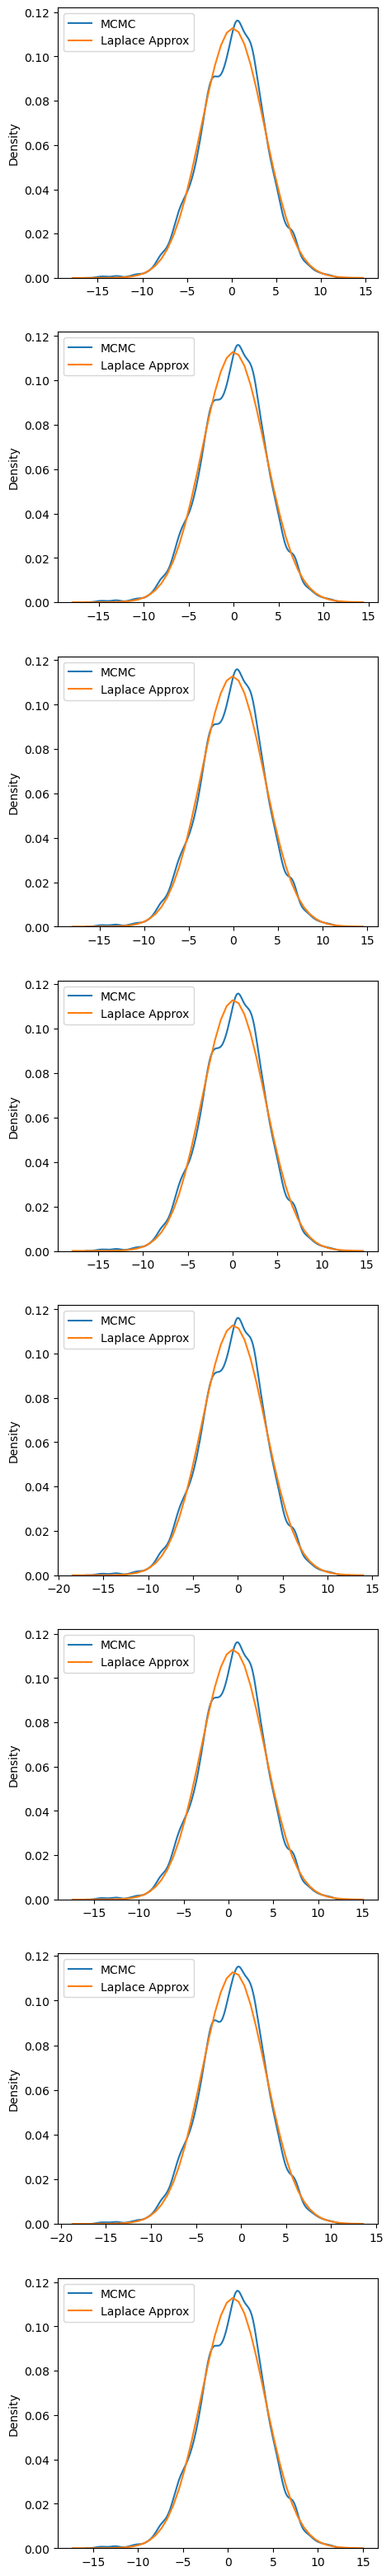

In [68]:
post_dim = posterior_values.shape[1]
laplace_mean = laplace_approx.mean
laplace_std = laplace_approx.covariance_matrix.diagonal()**0.5
fig, axes = plt.subplots(post_dim, 1, figsize=(5, 5 * post_dim))
for i in range(post_dim):
    ax = axes[i]
    sns.kdeplot(posterior_values[:, i], ax=ax, label="MCMC")
    
    xlim = ax.get_xlim()
    xs = jnp.linspace(xlim[0], xlim[1])
    ax.plot(xs, stats.norm.pdf(xs, loc=laplace_mean[i], scale=laplace_std[i]), label="Laplace Approx")
    
    ax.legend()
    
plt.show()